# Introducción a los modelos generativos de difusión

**Autor:** Saúl Álvarez Lázaro

**Fecha:** 22/07/25

## Introducción

Los modelos generativos han revolucionado el aprendizaje profundo, permitiéndonos crear datos nuevos y realistas. En los últimos años ha surgido una nueva clase de modelos con una potencia y estabilidad impresionantes: los **Modelos de Difusión Probabilística Denoising (DDPMs)**.

La idea central es:
1.  **Proceso Directo:** Se toma una imagen real y se le añade ruido gradualmente hasta que se convierte en ruido puro.
2.  **Proceso Inverso:** Se entrena una red neuronal para revertir este proceso, partiendo de ruido y eliminándolo iterativamente hasta generar una imagen nueva.

Este notebook implementa un DDPM utilizando TensorFlow para generar imágenes de dígitos del dataset MNIST y FashionMNIST.



In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


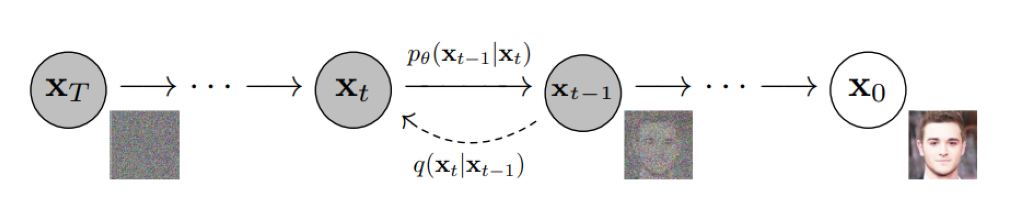

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/drive/MyDrive/imagenes/ProcesoInverso.png'

img = mpimg.imread(image_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

## Trabajo Relacionado

Este trabajo se basa principalmente en los conceptos presentados en:

* **"Denoising Diffusion Probabilistic Models" (Ho, Jain, and Abbeel, 2020):** El trabajo seminal que popularizó los DDPMs.
* **"U-Net: Convolutional Networks for Biomedical Image Segmentation" (Ronneberger, et al., 2015):** La arquitectura U-Net es la columna vertebral de la mayoría de los modelos de difusión.

### Motivación

Este trabajo surge como una continuación natural del proyecto desarrollado previamente en el curso de **Análisis Numérico**, donde se abordaron conceptos similares pero en un entorno mucho más simplificado y teórico. En ese proyecto anterior, el objetivo era estudiar la capacidad de una red neuronal para revertir un proceso de difusión aplicado a datos sintéticos.

En lugar de trabajar con imágenes reales, se utilizaban dos **nubes de puntos gaussianas en 2D**, a las cuales se les aplicaba ruido gaussiano para simular un proceso de degradación. Posteriormente, el modelo aprendía a reconstruir las distribuciones originales a partir del ruido, pero con una arquitectura muy simple: una red compuesta por **dos capas ReLU** y una **capa lineal** al final.

El presente trabajo toma esa misma idea central —revertir la difusión de ruido— y la extiende al caso de imágenes reales, utilizando arquitecturas más complejas como **U-Net**, y aplicando los conceptos en el marco de modelos de difusión generativa. De este modo, se mantiene el enfoque conceptual del proyecto anterior, pero se profundiza en su aplicación práctica y computacional.


### Proceso Directo

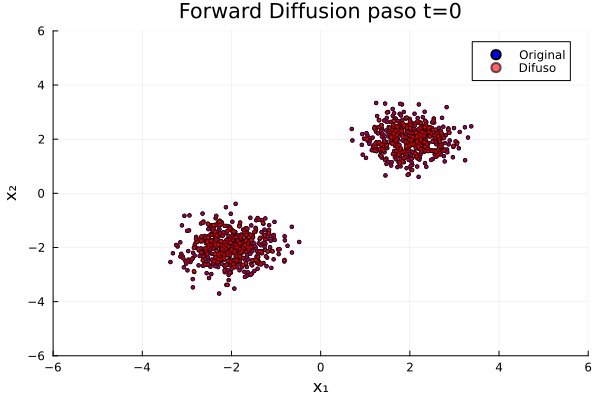

### Proceso Inverso

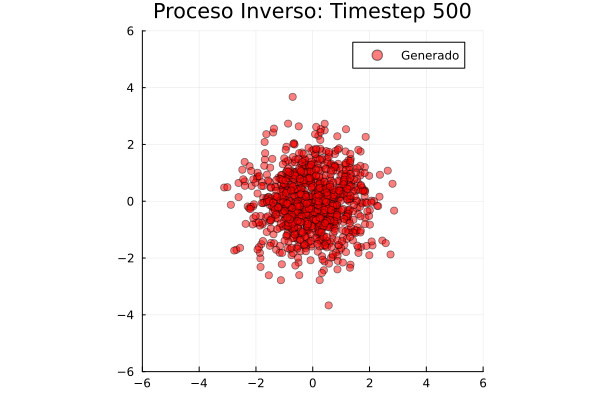

In [15]:
from IPython.display import display, Image, Markdown

display(Markdown("### Proceso Directo"))
display(Image(filename='/content/drive/MyDrive/imagenes/Procesodirecto.gif'))

display(Markdown("### Proceso Inverso"))
display(Image(filename='/content/drive/MyDrive/imagenes/Procesoinverso.gif'))


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 0. CONFIGURACIÓN ---
class Config:
    TIMESTEPS = 400
    IMG_SIZE = 32
    # Se ajusta el BATCH_SIZE para mejor compatibilidad con GPUs de Colab
    BATCH_SIZE = 2048
    EPOCHS = 50
    DEVICE = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"

print(f"Usando el dispositivo: {Config.DEVICE}")

# --- 1. DATOS ---
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = tf.image.resize(tf.expand_dims(x_train, -1), [Config.IMG_SIZE, Config.IMG_SIZE])
# Normalizamos los píxeles al rango [-1, 1]
x_train = (tf.cast(x_train, tf.float32) / 255.0 - 0.5) * 2
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(Config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Forma de los datos de entrenamiento: {x_train.shape}")

Usando el dispositivo: /GPU:0
Forma de los datos de entrenamiento: (60000, 32, 32, 1)


## Métodos

### Proceso de Difusión Directo (Forward Process)

El proceso de difusión directo es un procedimiento determinístico y no entrenable cuyo objetivo es degradar progresivamente una imagen original $x_0$ añadiendo ruido gaussiano en una secuencia de pasos temporales. Este proceso se ejecuta en $T$ pasos y es clave en los modelos de difusión, ya que define cómo se destruye la información antes de que el modelo aprenda a reconstruirla.

En cada paso de tiempo $t$, se introduce una pequeña cantidad de ruido controlada por un parámetro $\beta_t$, de modo que la imagen se va volviendo cada vez más ruidosa hasta que, en el paso final $x_T$, se aproxima a una muestra de ruido puro.

Lo más notable de este proceso es que no es necesario simular cada paso individualmente hasta llegar al paso $t$. En lugar de eso, existe una fórmula cerrada que permite calcular directamente el estado de la imagen en cualquier instante $t$ sin recorrer todos los pasos anteriores:

$$
x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon
$$

Donde:

- $x_0$ representa la imagen original (por ejemplo, un tensor de pixeles normalizado).
- $\epsilon \sim \mathcal{N}(0, \mathbf{I})$ es una muestra de ruido gaussiano estándar, es decir, una imagen de ruido puro.
- $\bar{\alpha}_t = \prod_{i=1}^{t} (1 - \beta_i)$ es el producto acumulado de los coeficientes de preservación $\alpha_i = 1 - \beta_i$, y controla cuánta de la señal original se conserva hasta el paso $t$.

La fórmula anterior refleja una combinación lineal entre la imagen original $x_0$ y el ruido puro $\epsilon$, ponderada por la cantidad de ruido acumulado hasta ese paso. A medida que $t$ crece, $\bar{\alpha}_t$ decrece, reduciendo la contribución de la imagen original y aumentando la del ruido, hasta que en $t = T$ la imagen se aproxima completamente a una muestra de la distribución gaussiana estándar.

Este proceso no necesita aprendizaje; simplemente define cómo se genera la trayectoria de degradación que luego será invertida por el modelo entrenado durante el proceso inverso.


In [17]:
# --- 2. DIFUSIÓN DIRECTA ---
betas = tf.linspace(0.0001, 0.02, Config.TIMESTEPS)
alphas = 1.0 - betas
alphas_cumprod = tf.math.cumprod(alphas)

def forward_diffusion(x0, t):
    """Aplica el proceso de difusión directo a un batch de imágenes."""
    noise = tf.random.normal(tf.shape(x0))
    a_t = tf.gather(alphas_cumprod, t)
    # Reajustamos la forma para la multiplicación (broadcasting)
    a_t = tf.reshape(a_t, [-1, 1, 1, 1])
    x_t = tf.sqrt(a_t) * x0 + tf.sqrt(1.0 - a_t) * noise
    return x_t, noise

### Proceso Inverso y Arquitectura del Modelo (U-Net)

El proceso inverso es la parte entrenable de los modelos de difusión. Su objetivo es deshacer la degradación generada por el proceso directo, es decir, recuperar progresivamente la imagen original $x_0$ a partir de una imagen ruidosa $x_T$. Sin embargo, en lugar de entrenar un modelo para predecir directamente la imagen limpia, se ha demostrado que es más efectivo que el modelo aprenda a predecir el **ruido** $\epsilon$ que fue añadido en cada paso.

Esta elección tiene varias ventajas teóricas y prácticas, ya que el problema se vuelve más estable y se alinea mejor con la estructura estadística de los datos. De este modo, una vez que el modelo ha aprendido a predecir el ruido en una imagen $x_t$ en el paso de tiempo $t$, podemos usar esa predicción para estimar la imagen "menos ruidosa" $x_{t-1}$.

**Resumen del modelo de `denoising`:**

- **Entrada:** Una imagen ruidosa $x_t$ y el paso de tiempo $t$.
- **Salida:** Una predicción del ruido original $\epsilon_\theta(x_t, t)$ que fue añadido durante el proceso de difusión.

### Arquitectura: U-Net

Para llevar a cabo esta tarea, se emplea una arquitectura basada en U-Net una red convolucional ampliamente utilizada en tareas de segmentación y reconstrucción de imágenes. La U-Net es especialmente adecuada para este problema debido a su capacidad para combinar información global y local gracias a sus `skip connections` (conexiones residuales entre capas de codificación y decodificación).

Estas `skip connections` permiten que la información espacial de alta resolución fluya directamente desde las capas iniciales hasta las finales, facilitando la recuperación de detalles finos en la imagen reconstruida.

Además, dado que el modelo necesita saber en qué paso de tiempo $t$ se encuentra (para ajustar la cantidad de ruido que debe remover), se codifica el valor de $t$ mediante un `embedding posicional sinusoidal`, una técnica inspirada en los `transformers`. Esta codificación transforma el escalar $t$ en un vector continuo y diferenciable que captura su posición relativa dentro del proceso de difusión.

En resumen:

- **Red principal:** U-Net convolucional con `skip connections`.
- **Condicionamiento temporal:** `Embeddings sinusoidales` del `timestep` $t$.
- **Objetivo del modelo:** Aprender a predecir el ruido gaussiano añadido, paso a paso, para reconstruir la imagen original.


In [18]:
# --- 3. MODELO UNET LIGERO ---
class SinusoidalPosEmb(layers.Layer):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def call(self, time):
        time = tf.cast(time, tf.float32)
        half_dim = self.dim // 2
        emb = tf.math.log(10000.0) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = tf.expand_dims(time, -1) * tf.expand_dims(emb, 0)
        return tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

class Block(layers.Layer):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_dense = layers.Dense(out_ch)
        self.up = up
        self.conv1 = layers.Conv2D(out_ch, 3, padding='same')
        self.conv2 = layers.Conv2D(out_ch, 3, padding='same')
        self.norm1 = layers.BatchNormalization()
        self.norm2 = layers.BatchNormalization()
        self.activation = tf.nn.relu
        self.transform = (
            layers.Conv2DTranspose(out_ch, 4, strides=2, padding='same') if up else
            layers.Conv2D(out_ch, 4, strides=2, padding='same')
        )

    def call(self, x, t_emb):
        h = self.norm1(self.activation(self.conv1(x)))
        t = self.activation(self.time_dense(t_emb))
        t = tf.reshape(t, [tf.shape(t)[0], 1, 1, tf.shape(t)[-1]])
        h = h + t
        h = self.norm2(self.activation(self.conv2(h)))
        return self.transform(h)

class SimpleUnet(Model):
    def __init__(self):
        super().__init__()
        down_channels = [32, 64, 128]
        up_channels = [128, 64, 32]
        time_emb_dim = 16
        self.time_mlp = tf.keras.Sequential([
            SinusoidalPosEmb(time_emb_dim),
            layers.Dense(time_emb_dim, activation='relu')
        ])
        self.init_conv = layers.Conv2D(down_channels[0], 3, padding='same')
        self.downs = [Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)]
        self.ups = []
        for i in range(len(up_channels)-1):
            # La entrada al bloque de subida tiene el doble de canales por la skip connection
            self.ups.append(Block(up_channels[i]*2, up_channels[i+1], time_emb_dim, up=True))
        self.out_conv = layers.Conv2D(1, 1, padding='same')

    def call(self, x, t):
        t_emb = self.time_mlp(t)
        x = self.init_conv(x)
        residuals = []
        for down in self.downs:
            x = down(x, t_emb)
            residuals.append(x)

        # Invertimos los residuales para usarlos en el camino de subida
        residuals = residuals[::-1]

        for i, up in enumerate(self.ups):
            # El último residual no se concatena, se usa como entrada para el primer bloque 'up'
            if i > 0:
              x = tf.concat([x, residuals[i]], axis=-1)
            x = up(x, t_emb)
        return self.out_conv(x)

### Entrenamiento y Función de Pérdida

El entrenamiento del modelo de difusión tiene como objetivo principal enseñarle a predecir el ruido que fue añadido artificialmente a una imagen limpia durante el proceso directo. En lugar de reconstruir directamente la imagen original $x_0$, el modelo aprende a estimar el ruido gaussiano $\epsilon$ que fue añadido en un paso de tiempo específico $t$.

Este enfoque tiene varias ventajas: al trabajar directamente con el ruido, el problema de aprendizaje se vuelve más uniforme y la función de pérdida más estable, ya que el ruido proviene de una distribución conocida (gaussiana estándar) y tiene propiedades estadísticas bien definidas.

Durante el entrenamiento, se siguen estos pasos:

1. Se toma una imagen original $x_0$ del dataset.
2. Se elige un `timestep` $t$ al azar (usualmente con una distribución uniforme entre $1$ y $T$).
3. Se genera una muestra de `ruido` $\epsilon \sim \mathcal{N}(0, \mathbf{I})$.
4. Se construye una imagen ruidosa $x_t$ usando la fórmula cerrada del proceso directo:

   $$
   x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon
   $$

5. Esta imagen $x_t$ junto con el valor de $t$ se entrega como entrada al modelo, que intenta predecir el mismo ruido $\epsilon$ utilizado para generarla.

La función de pérdida empleada es el **Error Cuadrático Medio (MSE)**, que mide la distancia entre el ruido real y el ruido predicho por el modelo. La forma explícita de la pérdida es:

$$
L(\theta) = \mathbb{E}_{t, x_0, \epsilon} \left[ \left\| \epsilon - \epsilon_{\theta}(x_t, t) \right\|^2 \right]
$$

donde:

- $\theta$ son los parámetros del modelo (por ejemplo, los pesos de la red neuronal).
- $\epsilon$ es el ruido real añadido.
- $\epsilon_{\theta}(x_t, t)$ es el ruido predicho por el modelo a partir de la imagen ruidosa $x_t$ y el `timestep` $t$.

Una vez entrenado, este modelo se puede utilizar en el `proceso inverso` para generar nuevas imágenes desde ruido puro, eliminando iterativamente el ruido predicho en cada paso.


In [19]:
# --- 4. ENTRENAMIENTO ---
model = SimpleUnet()
optimizer = tf.keras.optimizers.Adam(1e-3)
loss_fn = tf.keras.losses.MeanSquaredError()

@tf.function
def train_step(x_batch):
    batch_size = tf.shape(x_batch)[0]
    t = tf.random.uniform([batch_size], minval=0, maxval=Config.TIMESTEPS, dtype=tf.int32)
    with tf.GradientTape() as tape:
        xt, noise = forward_diffusion(x_batch, t)
        pred_noise = model(xt, t)
        loss = loss_fn(noise, pred_noise)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

# Bucle de entrenamiento
with tf.device(Config.DEVICE):
    for epoch in range(Config.EPOCHS):
        print(f"--- Epoch {epoch+1}/{Config.EPOCHS} ---")
        epoch_loss = 0.0
        num_batches = 0
        for batch in tqdm(train_dataset, desc=f"Epoch {epoch+1}"):
            loss = train_step(batch)
            epoch_loss += loss
            num_batches += 1
        avg_loss = epoch_loss / num_batches
        print(f"Loss final de la epoch: {avg_loss.numpy()}")

--- Epoch 1/50 ---


Epoch 1: 100%|██████████| 30/30 [00:47<00:00,  1.58s/it]


Loss final de la epoch: 0.8143258690834045
--- Epoch 2/50 ---


Epoch 2: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s]


Loss final de la epoch: 0.354215532541275
--- Epoch 3/50 ---


Epoch 3: 100%|██████████| 30/30 [00:19<00:00,  1.54it/s]


Loss final de la epoch: 0.25201064348220825
--- Epoch 4/50 ---


Epoch 4: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.20787042379379272
--- Epoch 5/50 ---


Epoch 5: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s]


Loss final de la epoch: 0.15092892944812775
--- Epoch 6/50 ---


Epoch 6: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s]


Loss final de la epoch: 0.1169428750872612
--- Epoch 7/50 ---


Epoch 7: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s]


Loss final de la epoch: 0.11767993867397308
--- Epoch 8/50 ---


Epoch 8: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.08985316753387451
--- Epoch 9/50 ---


Epoch 9: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.08387589454650879
--- Epoch 10/50 ---


Epoch 10: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.07904454320669174
--- Epoch 11/50 ---


Epoch 11: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.07627665996551514
--- Epoch 12/50 ---


Epoch 12: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.07465675473213196
--- Epoch 13/50 ---


Epoch 13: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.07593858987092972
--- Epoch 14/50 ---


Epoch 14: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.07793467491865158
--- Epoch 15/50 ---


Epoch 15: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s]


Loss final de la epoch: 0.08158080279827118
--- Epoch 16/50 ---


Epoch 16: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.06652574241161346
--- Epoch 17/50 ---


Epoch 17: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.06118578836321831
--- Epoch 18/50 ---


Epoch 18: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.07406188547611237
--- Epoch 19/50 ---


Epoch 19: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.07587996870279312
--- Epoch 20/50 ---


Epoch 20: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.06968898326158524
--- Epoch 21/50 ---


Epoch 21: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.058275267481803894
--- Epoch 22/50 ---


Epoch 22: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.05915231630206108
--- Epoch 23/50 ---


Epoch 23: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.05519247427582741
--- Epoch 24/50 ---


Epoch 24: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.06152685731649399
--- Epoch 25/50 ---


Epoch 25: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.05476998910307884
--- Epoch 26/50 ---


Epoch 26: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.056224703788757324
--- Epoch 27/50 ---


Epoch 27: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.055116914212703705
--- Epoch 28/50 ---


Epoch 28: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.05308469757437706
--- Epoch 29/50 ---


Epoch 29: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.054151494055986404
--- Epoch 30/50 ---


Epoch 30: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.05452798306941986
--- Epoch 31/50 ---


Epoch 31: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.06051335856318474
--- Epoch 32/50 ---


Epoch 32: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.05239172279834747
--- Epoch 33/50 ---


Epoch 33: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.04992539808154106
--- Epoch 34/50 ---


Epoch 34: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.055015239864587784
--- Epoch 35/50 ---


Epoch 35: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.05007772147655487
--- Epoch 36/50 ---


Epoch 36: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.04965181276202202
--- Epoch 37/50 ---


Epoch 37: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.054432883858680725
--- Epoch 38/50 ---


Epoch 38: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.04877138137817383
--- Epoch 39/50 ---


Epoch 39: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.051599837839603424
--- Epoch 40/50 ---


Epoch 40: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.04812603071331978
--- Epoch 41/50 ---


Epoch 41: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.0475652851164341
--- Epoch 42/50 ---


Epoch 42: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.05306190997362137
--- Epoch 43/50 ---


Epoch 43: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.05299299582839012
--- Epoch 44/50 ---


Epoch 44: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.04860229417681694
--- Epoch 45/50 ---


Epoch 45: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.05007241293787956
--- Epoch 46/50 ---


Epoch 46: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.046521954238414764
--- Epoch 47/50 ---


Epoch 47: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.04704546928405762
--- Epoch 48/50 ---


Epoch 48: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s]


Loss final de la epoch: 0.04675023630261421
--- Epoch 49/50 ---


Epoch 49: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Loss final de la epoch: 0.046826671808958054
--- Epoch 50/50 ---


Epoch 50: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]

Loss final de la epoch: 0.04643169417977333


### Proceso de Muestreo Inverso (Generación)

Una vez que el modelo ha sido entrenado para predecir el ruido en imágenes ruidosas $x_t$, podemos utilizarlo para generar nuevas imágenes a partir de ruido puro. Este proceso se conoce como muestreo inverso o generación, y es la contraparte del proceso de difusión directo.

El procedimiento comienza desde una muestra aleatoria $x_T \sim \mathcal{N}(0, \mathbf{I})$, es decir, una imagen completamente ruidosa. A partir de allí, el modelo realiza una secuencia de pasos hacia atrás en el tiempo, desde $t = T-1$ hasta $t = 0$, eliminando progresivamente el ruido en cada paso utilizando la predicción del ruido que ha aprendido durante el entrenamiento.

En cada paso $t$, el modelo estima el ruido presente en la imagen $x_t$, y utiliza esa estimación para construir una imagen menos ruidosa $x_{t-1}$. La fórmula general que describe este proceso es:

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \, \epsilon_{\theta}(x_t, t) \right) + \sigma_t z
$$

Donde:

- $x_t$ es la imagen en el paso actual.
- $\epsilon_{\theta}(x_t, t)$ es la predicción del ruido hecha por el modelo.
- $\alpha_t$ y $\bar{\alpha}_t$ son coeficientes del schedule de ruido, ya definidos durante el proceso directo.
- $z \sim \mathcal{N}(0, \mathbf{I})$ es una muestra de ruido gaussiano, utilizada para mantener la estocasticidad del muestreo.
- $\sigma_t$ es una desviación estándar asociada a la varianza del ruido residual (puede depender del schedule o fijarse manualmente).
- En el último paso ($t = 0$), el término de ruido $z$ se omite para evitar introducir ruido al resultado final.

Este proceso de muestreo se puede interpretar como una cadena de Markov que va refinando la imagen paso a paso, eliminando el ruido de manera controlada. En cada paso, el modelo da una pista sobre cómo se vería la imagen si tuviera un poco menos de ruido, y esta información se usa para construir la siguiente imagen.

El número total de pasos $T$ controla un compromiso entre calidad y tiempo de generación: a mayor $T$, el proceso es más gradual y produce resultados más detallados, pero también es más lento.

En resumen:

- **Entrada inicial:** Imagen completamente ruidosa $x_T$.
- **Iteración hacia atrás:** De $t = T - 1$ hasta $t = 0$.
- **En cada paso:** Se usa la predicción del ruido del modelo para remover ruido y generar $x_{t-1}$.
- **Resultado final:** Imagen generada $x_0$, que idealmente parece una muestra real del conjunto de datos.

Este mecanismo permite que los modelos de difusión generen imágenes de alta calidad de forma completamente no supervisada, simplemente aprendiendo a revertir el proceso de destrucción de imágenes.


In [20]:
# --- 5. MUESTREO INVERSO ---
@tf.function
def sample(n_images):
    """Genera imágenes nuevas a partir de ruido."""
    xt = tf.random.normal([n_images, Config.IMG_SIZE, Config.IMG_SIZE, 1])
    for i in reversed(range(Config.TIMESTEPS)):
        t = tf.ones([n_images], dtype=tf.int32) * i
        pred_noise = model(xt, t)

        alpha = tf.gather(alphas, t)
        alpha_cumprod_t = tf.gather(alphas_cumprod, t)
        beta = tf.gather(betas, t)

        alpha = tf.reshape(alpha, [-1, 1, 1, 1])
        beta = tf.reshape(beta, [-1, 1, 1, 1])
        alpha_cumprod_t = tf.reshape(alpha_cumprod_t, [-1, 1, 1, 1])

        xt = (1.0 / tf.sqrt(alpha)) * (
            xt - (beta / tf.sqrt(1.0 - alpha_cumprod_t)) * pred_noise)

        if i > 0:
            xt += tf.sqrt(beta) * tf.random.normal(tf.shape(xt))

    # Des-normalizamos la imagen final de [-1, 1] a [0, 1]
    return tf.clip_by_value((xt + 1) / 2, 0, 1)

In [ ]:
# --- 6. VISUALIZACIÓN ---
print("Generando imágenes...")
with tf.device(Config.DEVICE):
    images = sample(64)

# Convertir a NumPy en la CPU para manipular y mostrar
images_np = images.numpy()

# Reorganizar las imágenes en una cuadrícula de 8x8
images_reshaped = np.reshape(images_np, [8, 8, Config.IMG_SIZE, Config.IMG_SIZE])
images_transposed = np.transpose(images_reshaped, [0, 2, 1, 3])
final_image = np.reshape(images_transposed, [8 * Config.IMG_SIZE, 8 * Config.IMG_SIZE])

plt.figure(figsize=(10, 10))
plt.imshow(final_image, cmap='gray')
plt.axis('off')
plt.savefig("mnist_generated_tf.png")

print("Imágenes generadas y guardadas en 'mnist_generated_tf.png'")

 ### Pruebas Con MNIST: Comparación De Tres Configuraciones

Para evaluar el impacto del tamaño del lote, la cantidad de pasos de difusión (`TIMESTEPS`) y el número de épocas sobre la calidad de generación de imágenes, se realizaron **tres pruebas distintas** utilizando el dataset MNIST con diferentes configuraciones:

| Configuración | `TIMESTEPS` | `BATCH_SIZE` | `EPOCHS` | Enfoque |
|---------------|-------------|--------------|----------|---------|
| **Baja**      | 150         | 128          | 10       | Entrenamiento rápido, ideal para pruebas o hardware limitado. |
| **Media**     | 300         | 1024         | 25       | Balance entre rendimiento, calidad y velocidad. |
| **Alta**      | 400         | 2048         | 50       | Optimizada para uso intensivo de GPU y generación de alta calidad. |

**Objetivo del experimento:** observar cómo afecta el escalamiento de los hiperparámetros a la calidad final de las imágenes generadas. Estas pruebas permiten comparar velocidad, uso de recursos y fidelidad visual bajo distintos escenarios.

### Resultados

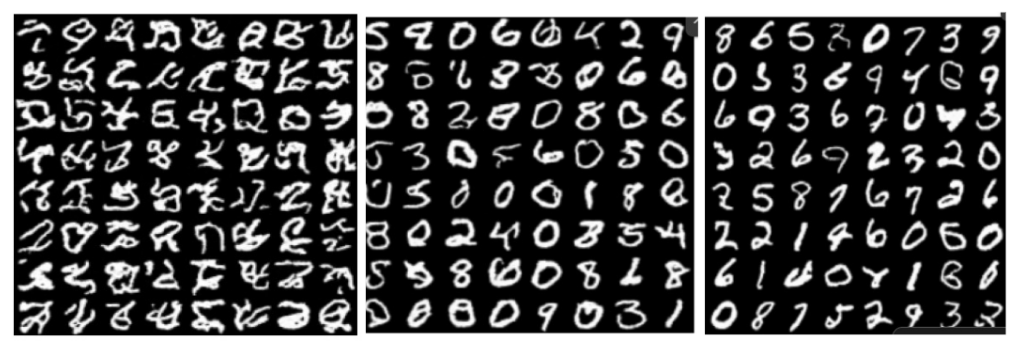

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ruta de la imagen en tu Google Drive
image_path = '/content/drive/MyDrive/imagenes/Prueba1.png'

# Cargar la imagen
img = mpimg.imread(image_path)

# Mostrar la imagen sin ejes ni bordes, en tamaño grande
plt.figure(figsize=(10, 10))  # Puedes aumentar este tamaño si quieres
plt.imshow(img)
plt.axis('off')  # Quita ejes
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Quita márgenes
plt.show()


### Pruebas con Otros Datasets

Además del conjunto de datos principal, también se realizaron pruebas utilizando el dataset **Fashion-MNIST**. Este dataset fue útil para validar el comportamiento del modelo en un dominio ligeramente más complejo que MNIST, manteniendo una estructura similar en términos de formato y tamaño de imagen.

Adicionalmente, se intentaron realizar pruebas con el dataset **CIFAR-10**, que contiene imágenes a color de 32×32 píxeles pertenecientes a 10 clases diferentes. Sin embargo, debido a las limitaciones de **cómputo gráfico en el entorno de Google Colab**, los resultados obtenidos no fueron satisfactorios. En particular, la generación de imágenes no mostró convergencia adecuada y la calidad de los outputs fue deficiente, probablemente debido al mayor tamaño del modelo requerido para manejar imágenes a color y a la complejidad del dataset.

Estos experimentos muestran que, si bien el modelo puede generalizar a otros dominios, su desempeño depende fuertemente de la capacidad computacional disponible para el entrenamiento.


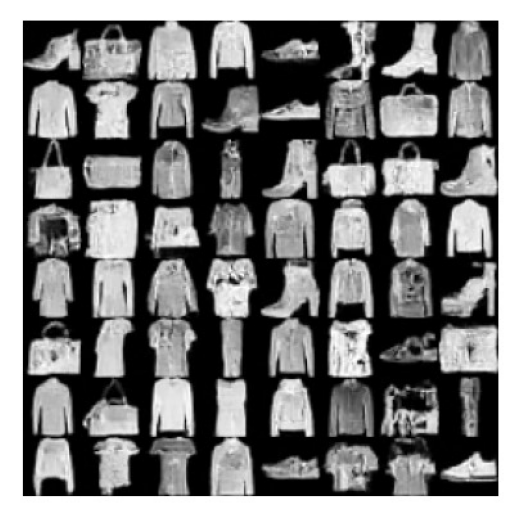

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ruta de la imagen en tu Google Drive
image_path = '/content/drive/MyDrive/imagenes/PruebaFashion.jpg'

# Cargar la imagen
img = mpimg.imread(image_path)

# Mostrar la imagen sin ejes ni bordes, en tamaño grande
plt.figure(figsize=(5, 5))  # Puedes aumentar este tamaño si quieres
plt.imshow(img)
plt.axis('off')  # Quita ejes
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Quita márgenes
plt.show()

## Conclusiones

Este trabajo permitió explorar de forma práctica y estructurada el funcionamiento de los modelos de difusión aplicados a la generación de imágenes.

- **Aprendizaje clave:** La idea de descomponer la generación de imágenes en una secuencia de pasos de eliminación de ruido demostró ser una estrategia robusta y conceptualmente clara. El enfoque gradual permite al modelo aprender a aproximar distribuciones complejas de datos de forma estable y controlada.

- **Decisiones de diseño efectivas:**
  - La decisión de **predecir el ruido** en lugar de la imagen directamente no solo simplifica la función de pérdida, sino que también mejora la estabilidad del entrenamiento y la generalización del modelo.
  - La arquitectura **U-Net**, con sus `skip connections`, demostró ser altamente adecuada para esta tarea, ya que preserva detalles espaciales mientras permite un procesamiento jerárquico de la información.
  - El uso de **embeddings sinusoidales de tiempo** como entrada adicional le proporciona al modelo un contexto explícito sobre el paso de difusión, lo cual es esencial para ajustar dinámicamente el nivel de denoising.

- **Experimentos y validación:**
  - Se realizaron pruebas exitosas con el dataset **Fashion-MNIST**, donde el modelo fue capaz de aprender la estructura de las imágenes y generar muestras visualmente coherentes.
  - Aunque se intentó aplicar el modelo a **CIFAR-10**, las limitaciones de cómputo en Google Colab impidieron alcanzar una calidad aceptable, evidenciando la necesidad de arquitecturas más grandes o más recursos de entrenamiento para datasets a color y de mayor complejidad.

En conjunto, el proyecto no solo profundiza en los fundamentos de los modelos generativos, sino que también muestra cómo una idea matemática relativamente simple —revertir la adición de ruido— puede extenderse a sistemas altamente expresivos y útiles en la práctica.
